- num. Tokens by category
- num. Fragments by category
- Fragment sizes
- Fragment paper types
- Most popular:
    - authorities
    - body parts
    - ailments
    - treatments
    - ingredients
    - Co-occurance of these?

In [1]:
import altair as alt
import pandas as pd

alt.data_transformers.enable('json')

/home/hal/.local/share/virtualenvs/genizah-visualisation-mG8BC0xT/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


DataTransformerRegistry.enable('json')

In [2]:
token_types = pd.read_csv('../medical-data/token-types.csv', index_col='token')
token_types.head()

,type
token,
abcess,ailment
abcesses,ailment
abdomen,body_part
abdominal,body_part
abnormal,ailment


In [3]:
fragment_tokens = pd.read_csv('../medical-data/fragment-tokens.csv')
fragment_tokens.head()

,classmark,token
0,MS-OR-01080-00001-00063,pharmacopoeia
1,MS-OR-01080-00001-00063,containing
2,MS-OR-01080-00001-00063,diagram
3,MS-OR-01080-00001-00063,and
4,MS-OR-01080-00001-00063,symbol


In [4]:
fragment_tokens = pd.merge(fragment_tokens, token_types, 
                  left_on='token', right_index=True,
                  sort=False, validate='m:1')
fragment_tokens.head()

,classmark,token,type
0,MS-OR-01080-00001-00063,pharmacopoeia,treatment
177,MS-MOSSERI-III-00085-00001,pharmacopoeia,treatment
1498,MS-TS-AR-00039-00020,pharmacopoeia,treatment
1730,MS-TS-AR-00039-00091,pharmacopoeia,treatment
3411,MS-TS-AR-00039-00462,pharmacopoeia,treatment


In [5]:
fragments = pd.read_json('../medical-data/genizah-medical.json', orient='index')
fragments.index.name = 'classmark'
fragments = fragments.reset_index()
fragments.head()

,classmark,columns,date_end,date_start,height,lines,material,summary,title,width
0,MS-OR-01080-00001-00063,1.0,1899-12-31,0500-01-01,21.2,21.0,paper,"Pharmacopoeia, containing diagrams and symbols...",Medical,14.3
1,MS-OR-01080-00001-00072,1.0,1899-12-31,0500-01-01,36.4,22.0,vellum,"Discussion of various medical treatments, regi...",Medical,16.8
2,MS-OR-01080-00001-00081,1.0,1899-12-31,0500-01-01,25.4,12.0,paper,"Medical work on the composition of the body, c...",Medical,16.8
3,MS-OR-01080-00001-00087,1.0,1233-12-31,1213-01-01,NaN,5.0,paper,Recto: a short medical recipe. Verso: a respon...,Medical,NaN
4,MS-OR-01080-00002-00070,1.0,1199-12-31,1100-01-01,31.5,35.0,paper,Autograph draft of a medical work by Moses Mai...,Medical,22.8


In [6]:
fragments.shape

(1565, 10)

## Fragment Materials

In [7]:
material_counts = (pd.DataFrame(fragments.groupby('material').size(), columns=['count'])
    .reset_index())
material_counts

,material,count
0,cardboard,1
1,cloth,2
2,paper,1490
3,vellum,71


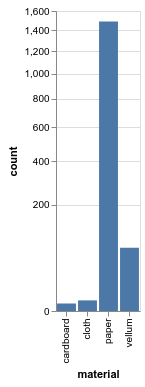

In [8]:
alt.Chart(material_counts).mark_bar().encode(
    alt.X('material:N'),
    y=alt.Y('count:Q', scale=alt.Scale(type='pow', exponent=0.5)),
    tooltip='count'
)

## Fragment Sizes

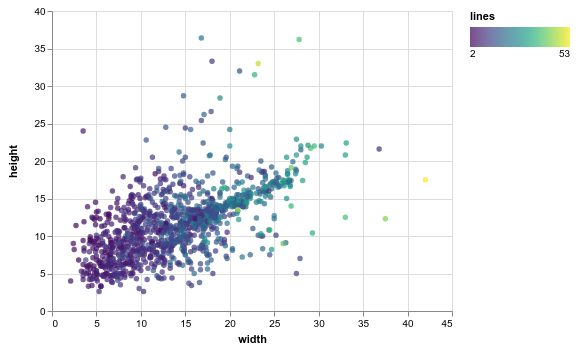

In [9]:
alt.Chart(fragments).mark_circle().encode(
    alt.X('width:Q'),
    alt.Y('height:Q'),
    color=alt.Color('lines:Q', bin=False, scale=alt.Scale(scheme='viridis')),
    tooltip='classmark'
).interactive()

## Tokens

### Token Types

In [10]:
fragment_tokens.head()

,classmark,token,type
0,MS-OR-01080-00001-00063,pharmacopoeia,treatment
177,MS-MOSSERI-III-00085-00001,pharmacopoeia,treatment
1498,MS-TS-AR-00039-00020,pharmacopoeia,treatment
1730,MS-TS-AR-00039-00091,pharmacopoeia,treatment
3411,MS-TS-AR-00039-00462,pharmacopoeia,treatment


In [11]:
tokens_per_type = (fragment_tokens[['type', 'token']].drop_duplicates()
    .groupby(['type'])
    .count())
fragments_per_type = (fragment_tokens[['type', 'classmark']].drop_duplicates()
    .groupby(['type'])
    .count())

for df in [tokens_per_type, fragments_per_type]:
    df.rename(columns=lambda c: 'count', inplace=True)

tokens_per_type['count_type'] = 'tokens'
fragments_per_type['count_type'] = 'fragments'

token_type_counts = (pd.concat([tokens_per_type, fragments_per_type], sort=False))
token_type_counts

,count,count_type
type,,
ailment,402,tokens
authority,48,tokens
body_part,185,tokens
ingredient,469,tokens
treatment,211,tokens
ailment,799,fragments
authority,329,fragments
body_part,724,fragments
ingredient,564,fragments


In [12]:
def display_values(field=None, mapping=None, display_field_name=None):
    if display_field_name is None:
        display_field_name = f'{field}_display'
    
    lookup_frame = pd.DataFrame.from_records(list(mapping.items()), columns=[field, display_field_name])
    return alt.LookupData(data=lookup_frame, key=field, fields=[display_field_name])

In [13]:
type_display_tx = display_values('type', {
    'ailment': 'Ailment',
    'authority': 'Authority',
    'body_part': 'Body part',
    'ingredient': 'Ingredient',
    'treatment': 'Treatment'
})
count_type_display_tx = display_values('count_type', {
    'fragments': 'Fragments',
    'tokens': 'Tokens'
})

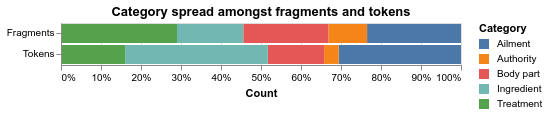

In [14]:
(alt.Chart(token_type_counts.reset_index(), title='Category spread amongst fragments and tokens')
  .mark_bar()
  .encode(
    alt.X('count:Q', axis=alt.Axis(title='Count', format='%'), stack='normalize'),
    alt.Y('count_type_display:N', axis=alt.Axis(title=None)),
    color=alt.Color('type_display:N', title='Category'),
    tooltip=['count:Q']
  )
  .transform_lookup(lookup='type', from_=type_display_tx)
  .transform_lookup(lookup='count_type', from_=count_type_display_tx))

## Token usage frequency

In [15]:
fragments_per_token = (pd.DataFrame(fragment_tokens.groupby('token').size(), 
                                    columns=['count']))
fragments_per_token = fragments_per_token.merge(token_types, left_index=True, right_index=True)
fragments_per_token.sort_values(by='count', ascending=False).head()

,count,type
token,,
treatment,209,treatment
simple,180,ingredient
eye,155,body_part
medicine,150,treatment
disease,142,ailment


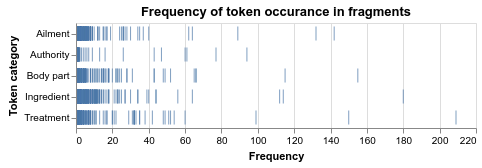

In [16]:
(alt.Chart(fragments_per_token, title='Frequency of token occurance in fragments')
  .mark_tick()
  .encode(
      alt.X('count:Q', title='Frequency'),
      alt.Y('type_display:N', title='Token category')
  )
  .transform_lookup(lookup='type', from_=type_display_tx)
)

## Top Terms

Wordcloud visualising terms. Terms are coloured according to category and sized according to number of fragments they appear in.

In [17]:
term_occurrences = (pd.merge(
        pd.DataFrame(fragment_tokens.groupby('token').aggregate('size'), columns=['occurrences']), 
        fragment_tokens[['token', 'type']].drop_duplicates(), 
        left_index=True, right_on='token')
    # Seems that Vega doesn't lay out the word cloud correctly if the text field isn't called "text".
    # Perhaps there's a default value referencing the text field, but I couldn't find one...
    .rename(columns={'token': 'text'}))
term_occurrences.text = term_occurrences.text.str.upper()
(term_occurrences.to_csv('./vega-term-occurrences.csv', index=False))

(term_occurrences
     .sort_values(['occurrences', 'text'], ascending=False)
     .head())

,occurrences,text,type
28,209,TREATMENT,treatment
143,180,SIMPLE,ingredient
1377,155,EYE,body_part
467,150,MEDICINE,treatment
563,142,DISEASE,ailment


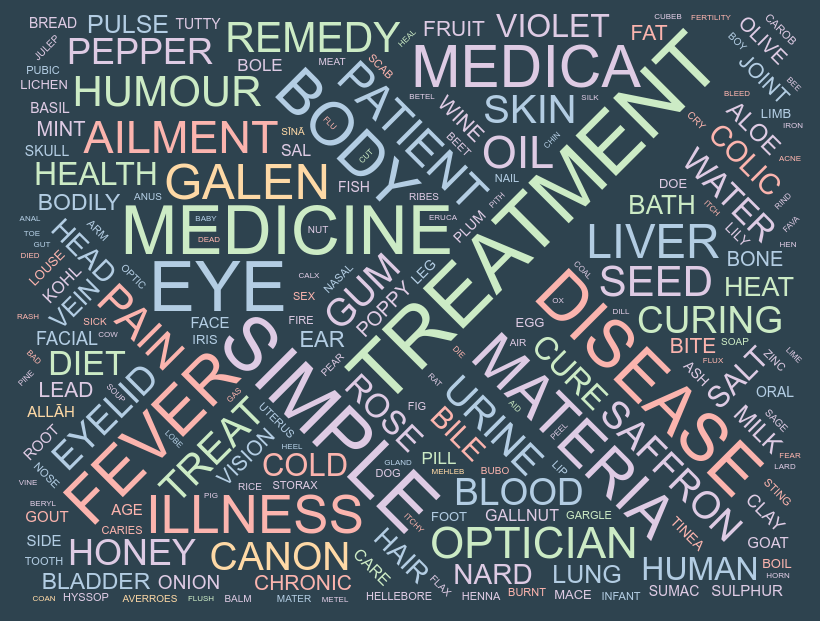

In [18]:
# Vega lite doesn't support word clouds, but Vega itself does, so we'll use that directly.

# Based on Vega's Word Cloud example: https://vega.github.io/vega/examples/word-cloud/
term_occurrences_wordcloud_json = {
  "$schema": "https://vega.github.io/schema/vega/v3.json",
  "width": 800,
  "height": 600,
  "padding": 10,
  "config": {
    "background": "#2e434f"  
  },
  "data": [
    {
      "name": "term-occurrences", 
      "url": "vega-term-occurrences.csv",
      "format": {"type": "csv"},
      "transform": [
        {
          "type": "formula", "as": "angle",
          "expr": "[-45, 0, 45][round(random() * 3)]"
        }
      ]
    }
  ],

  "scales": [
    {
      "name": "color",
      "type": "ordinal",
      "domain": {"data": "term-occurrences", "field": "type"},
      "range": {"scheme": "pastel1"}
    }
  ],

  "marks": [
    {
      "type": "text",
      "from": {"data": "term-occurrences"},
      "encode": {
        "enter": {
          "text": {"field": "text"},
          "align": {"value": "center"},
          "baseline": {"value": "alphabetic"},
          "fill": {"scale": "color", "field": "type"}
        },
        "update": {
          "fillOpacity": {"value": 1}
        },
        "hover": {
          "fillOpacity": {"value": 0.65}
        }
      },
      "transform": [
        {
          "type": "wordcloud",
          "size": [800, 600],
          "text": {"field": "text"},
          "rotate": {"field": "datum.angle"},
          "font": "Helvetica Neue, Arial",
          "fontSize": {"field": "datum.occurrences"},
          "fontSizeRange": [8, 56],
          "padding": 2
        }
      ]
    }
  ]
}

import altair.vega.v3
alt.vega.v3.vega(term_occurrences_wordcloud_json)

### Top terms table

List the most frequently appearing terms in each category.

In [19]:
(term_occurrences.groupby('type')
     .apply(lambda g: g.sort_values(['occurrences', 'text'], ascending=[False, True])
                       .assign(rank=range(1, len(g) + 1)))
     .set_index(['type', 'rank'])
     .unstack(0)
     .swaplevel(0, 1, axis=1)
     .sort_index(1)
     .head(30))

type     ailment                 authority                 body_part  \
     occurrences          text occurrences          text occurrences   
rank                                                                   
1          142.0       DISEASE        94.0   HIPPOCRATES       155.0   
2          132.0         FEVER        77.0         GALEN       115.0   
3           89.0       ILLNESS        61.0      AVICENNA        66.0   
4           64.0       AILMENT        60.0   AL-KAḤḤĀLĪN        66.0   
5           62.0          PAIN        47.0         CANON        65.0   
6           40.0       SYMPTOM        43.0    MAIMONIDES        52.0   
7           37.0        SEXUAL        26.0        TIBBON        49.0   
8           35.0      HEADACHE        16.0        DOCTOR        48.0   
9           34.0  INFLAMMATION        13.0       GALENIC        43.0   
10          30.0     DIARRHOEA         9.0   DIOSCORIDES        43.0   
11          28.0          COLD         7.0      DRUGGIST        31.0   
12          27.0         ULCER         6.0         ALLĀH        28.0   
13          26.0         COLIC         5.0   HIPPOCRATIC        28.0   
14          26.0         COUGH         4.0     ARISTOTLE        25.0   
15          26.0         WOUND         3.0  ARISTOLOCHIA        24.0   
16          25.0          BILE         2.0      AVERROES        23.0   
17          24.0       ABSCESS         2.0       FEBRIUM        23.0   
18          19.0         SLEEP         2.0        JUMAYʿ        22.0   
19          17.0      CATARACT         2.0       MEDENDI        22.0   
20          17.0       URINARY         2.0          SĪNĀ        20.0   
21          16.0      VOMITING         1.0   AESCULAPIUS        18.0   
22          15.0     DIGESTION         1.0      AFFECTIS        18.0   
23          15.0     PATHOLOGY         1.0   AL-KAḤḤALĪN        18.0   
24          13.0      APPETITE         1.0    AL-KAḤḤLĪN        18.0   
25          12.0          BITE         1.0     AL-KAḤḤĀL        17.0   
26          12.0       CHRONIC         1.0      AL-KINDĪ        16.0   
27          12.0           FAT         1.0     ALCHEMIST        16.0   
28          10.0     SUFFERING         1.0         ANIMA        15.0   
29           9.0      ALOPECIA         1.0    APPRENTICE        15.0   
30           9.0      JAUNDICE         1.0    ARCHIGENES        15.0   

type             ingredient                treatment                    
           text occurrences         text occurrences              text  
rank                                                                    
1           EYE       180.0       SIMPLE       209.0         TREATMENT  
2          BODY       114.0       MEDICA       150.0          MEDICINE  
3         LIVER       112.0      MATERIA        99.0     PHARMACOPOEIA  
4       PATIENT        64.0          OIL        60.0          OPTICIAN  
5       STOMACH        56.0         SEED        54.0            HUMOUR  
6       ANATOMY        44.0          GUM        52.0            REMEDY  
7          SKIN        44.0      SAFFRON        51.0        MEDICAMENT  
8         URINE        40.0       PEPPER        49.0             TREAT  
9         BLOOD        39.0        HONEY        48.0     OPHTHALMOLOGY  
10       EYELID        34.0         ROSE        42.0            CURING  
11        HUMAN        34.0        WATER        38.0          TREATING  
12       KIDNEY        30.0       VIOLET        35.0              DIET  
13        ORGAN        27.0    MYROBALAN        35.0        PHLEBOTOMY  
14         HAND        27.0         SALT        33.0  OPHTHALMOLOGICAL  
15         HEAD        25.0     CINNAMON        32.0              CURE  
16        BRAIN        24.0        SUGAR        32.0            HEALTH  
17       MUSCLE        23.0      CAMPHOR        32.0          OINTMENT  
18         HAIR        23.0       MASTIC        32.0            POTION  
19       SPLEEN        23.0         NARD        32.0      PRESCRIPTION  
20         WOMB  

# Pairs

In [20]:
co = pd.merge(fragment_tokens[['classmark', 'token']], fragment_tokens[['classmark', 'token']], 
                          how='inner', on='classmark')
# Ignore co-occurances between the same tokens
co = co[co['token_x'] != co['token_y']]

co_canonical = co[['token_x', 'token_y']].reset_index().melt(id_vars=['index']).sort_values(['index', 'value']).set_index('index')[['value']]
co['token_x'], co['token_y'] = co_canonical[::2], co_canonical[1::2]

co

,classmark,token_x,token_y
1,MS-OR-01080-00001-00063,pharmacopoeia,treat
2,MS-OR-01080-00001-00063,headache,pharmacopoeia
3,MS-OR-01080-00001-00063,pharmacopoeia,urine
4,MS-OR-01080-00001-00063,pharmacopoeia,toothache
5,MS-OR-01080-00001-00063,facial,pharmacopoeia
6,MS-OR-01080-00001-00063,palsy,pharmacopoeia
7,MS-OR-01080-00001-00063,pharmacopoeia,treat
9,MS-OR-01080-00001-00063,headache,treat
10,MS-OR-01080-00001-00063,treat,urine
11,MS-OR-01080-00001-00063,toothache,treat


In [21]:
co_occurrences = pd.merge(fragment_tokens[['classmark', 'token']], fragment_tokens[['classmark', 'token']], 
                          how='inner', on='classmark')
# Ignore co-occurances between the same tokens
co_occurrences = co_occurrences[co_occurrences['token_x'] != co_occurrences['token_y']]

# Only count a token pair once for a document. This is done by canonicalising 
# the pairs by making token_x < token_y lexicographically and then dropping
# duplicates.
co_oc_canonical = (co_occurrences[['token_x', 'token_y']]
                   .reset_index()
                   .melt(id_vars=['index'])
                   .sort_values(['index', 'value'])
                   .set_index('index')
                   [['value']])
co_occurrences['token_x'], co_occurrences['token_y'] = co_canonical[::2], co_canonical[1::2]
co_occurrences = co_occurrences.drop_duplicates()

co_occurrences

,classmark,token_x,token_y
1,MS-OR-01080-00001-00063,pharmacopoeia,treat
2,MS-OR-01080-00001-00063,headache,pharmacopoeia
3,MS-OR-01080-00001-00063,pharmacopoeia,urine
4,MS-OR-01080-00001-00063,pharmacopoeia,toothache
5,MS-OR-01080-00001-00063,facial,pharmacopoeia
6,MS-OR-01080-00001-00063,palsy,pharmacopoeia
9,MS-OR-01080-00001-00063,headache,treat
10,MS-OR-01080-00001-00063,treat,urine
11,MS-OR-01080-00001-00063,toothache,treat
12,MS-OR-01080-00001-00063,facial,treat


In [22]:
co_oc_counts = (co_occurrences
                .groupby(['token_x', 'token_y'])
                .size()
                .reset_index()
                .rename(columns={0: 'count'})
                .sort_values('count', ascending=False))

# Add types
co_oc_counts = pd.merge(co_oc_counts, token_types.rename(columns={'type': 'type_x'}), 
                          left_on='token_x', right_index=True, how='left')
co_oc_counts = pd.merge(co_oc_counts, token_types.rename(columns={'type': 'type_y'}), 
                          left_on='token_y', right_index=True, how='left')
co_oc_counts

,token_x,token_y,count,type_x,type_y
17935,materia,medica,111,ingredient,ingredient
18159,medica,simple,67,ingredient,ingredient
18014,materia,simple,66,ingredient,ingredient
1133,al-kaḥḥālīn,optician,58,authority,treatment
3473,avicenna,medicine,52,authority,treatment
3389,avicenna,canon,47,authority,authority
6671,canon,medicine,47,authority,treatment
11050,disease,treatment,32,ailment,treatment
12506,eye,treatment,29,body_part,treatment
12416,eye,ophthalmology,29,body_part,treatment


In [23]:
(co_oc_counts['count'] > 10).sum()

63

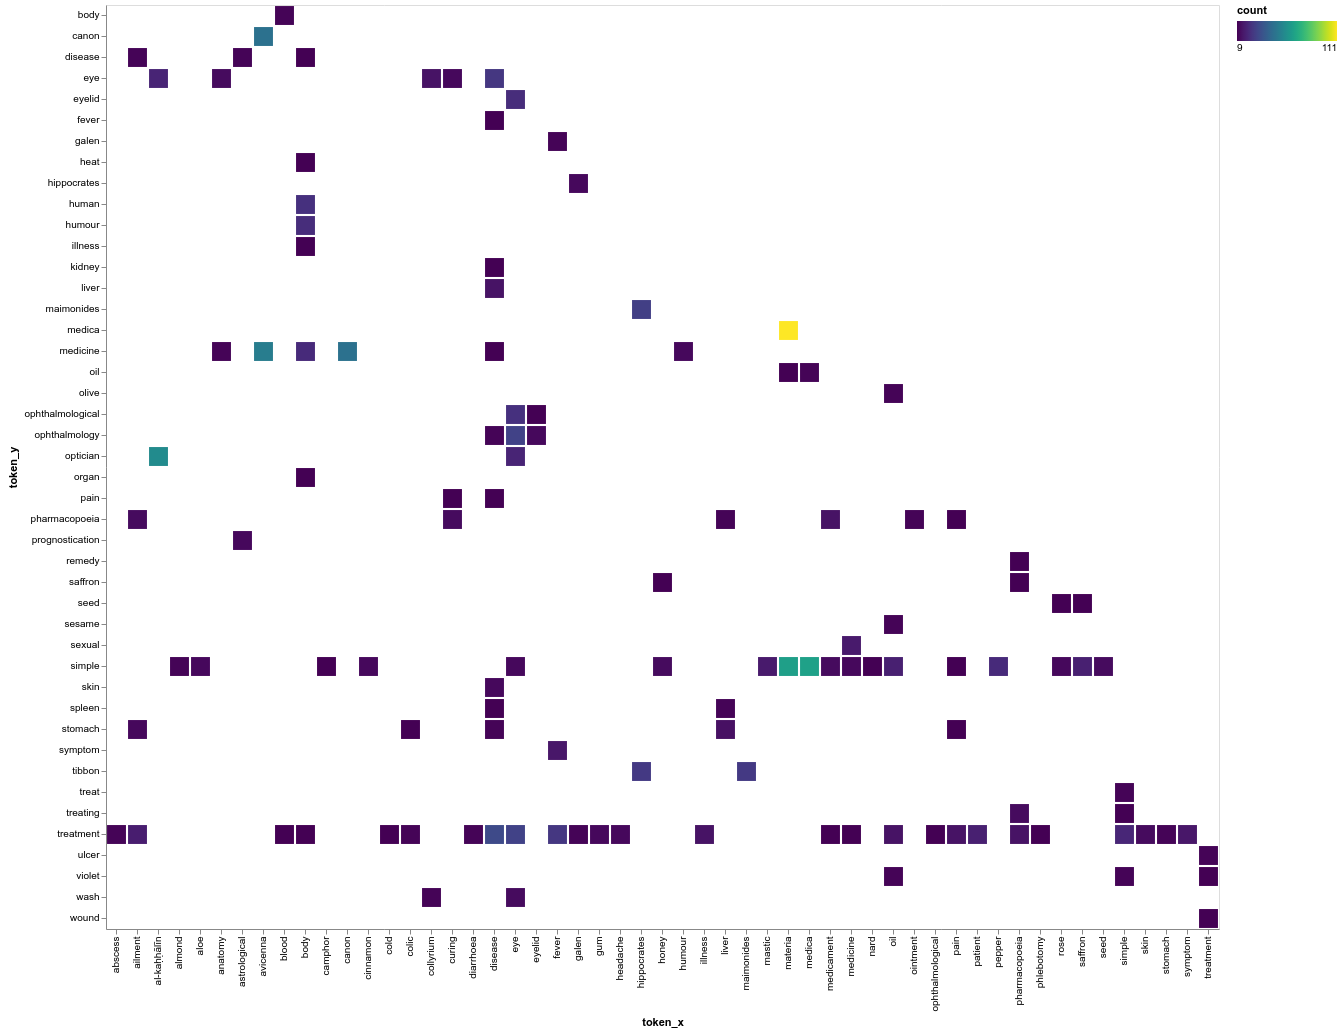

In [24]:
alt.Chart(co_oc_counts[co_oc_counts['count'] > 8]).mark_rect().encode(
    x='token_x:N',
    y='token_y:N',
    color='count:Q'
)

# Edge bundling

In [25]:
import re

def drop_column_suffix(name):
    return re.sub(r'(_[a-z]+)?$', '', name)

In [26]:
drop_column_suffix('foo_x')

'foo'

In [27]:
re.search(r'(_[a-z]+)?$', 'foo_x').groups()

('_x',)

In [32]:
co_oc_counts.head()

,token_x,token_y,count,type_x,type_y
17935,materia,medica,111,ingredient,ingredient
18159,medica,simple,67,ingredient,ingredient
18014,materia,simple,66,ingredient,ingredient
1133,al-kaḥḥālīn,optician,58,authority,treatment
3473,avicenna,medicine,52,authority,treatment


In [59]:
# We're going to organise tokens hierachically by category. Using Vega's nest transform
# would seem to be easiest, but it doesn't seem to provide a way to specify node IDs, which
# we need in order to provide the co-occurance relationships. Instead we'll have to provide
# a list of nodes with parent pointers and use the stratisfy transform to produce a tree.

eb_nodes = pd.DataFrame([{'parent': None, 'label': 'root', 'type': 'root'}])

# The pairs we'll include in the visualisation
eb_pairs = co_oc_counts[co_oc_counts['count'] > 8]

eb_leaves = pd.concat(
    [eb_pairs[['token_x', 'type_x']].rename(columns=drop_column_suffix), 
     eb_pairs[['token_y', 'type_y']].rename(columns=drop_column_suffix)]
).drop_duplicates()

_type_nodes = eb_leaves[['type']].drop_duplicates().rename(columns={'type': 'label'})
_type_nodes['parent'] = eb_nodes.iloc[0].name
_type_nodes['type'] = 'category'

eb_nodes = pd.concat([eb_nodes, _type_nodes], ignore_index=True)

eb_leaf_nodes = (
    pd.merge(eb_leaves, 
         eb_nodes[eb_nodes['type'] == 'category'].reset_index()[['index', 'label']], 
         left_on='type', right_on='label')
    [['token', 'index']]
    .rename(columns={'token': 'label', 'index': 'parent'}))
eb_leaf_nodes['type'] = 'token'
eb_leaf_nodes

eb_nodes = pd.concat([eb_nodes, eb_leaf_nodes], ignore_index=True)
eb_nodes.head(10)

,label,parent,type
0,root,None,root
1,ingredient,0,category
2,authority,0,category
3,ailment,0,category
4,body_part,0,category
5,treatment,0,category
6,materia,1,token
7,medica,1,token
8,pepper,1,token
9,simple,1,token


In [60]:
# We're going to organise tokens hierachically by category. We'll use Vega's nest transform
# to produce the tree, so we just need to give it a table of token,category pairs

# The pairs we'll include in the visualisation
# eb_pairs = co_oc_counts[co_oc_counts['count'] > 8]

# eb_leaves = pd.concat(
#     [eb_pairs[['token_x', 'type_x']].rename(columns=drop_column_suffix), 
#      eb_pairs[['token_y', 'type_y']].rename(columns=drop_column_suffix)]
# ).drop_duplicates().reset_index(drop=True)
# eb_leaves.index.name = 'id'

# eb_leaves.head()

In [77]:
# We need to give Vega data on the relationships between nodes - the co-occurance frequencies.
# Our links are symmetrical, so we create links in both directions with the same counts.
eb_links_forward = (
    eb_pairs[['token_x', 'token_y', 'count']]
        .rename(columns={'token_x': 'source', 'token_y': 'target'})
        .reset_index(drop=True))
eb_links_backward = (
    eb_links_forward.rename(columns={'source': 'target', 'target': 'source'})
        [['source', 'target', 'count']])

_token_ids = eb_nodes[eb_nodes['type'] == 'token'][['label']].reset_index().set_index('label')

eb_links = pd.concat([
    eb_links_forward, 
#     eb_links_backward
]).sort_index()
eb_links = pd.merge(eb_links, _token_ids.rename(columns=lambda x: 'source_id'), left_on='source', right_index=True)
eb_links = pd.merge(eb_links, _token_ids.rename(columns=lambda x: 'target_id'), left_on='target', right_index=True)
eb_links_ids = eb_links[['source_id', 'target_id', 'count']]

eb_links.head()

,source,target,count,source_id,target_id
0,materia,medica,111,6,7
2,materia,simple,66,6,9
1,medica,simple,67,7,9
50,eye,simple,11,46,9
19,pepper,simple,21,8,9


In [78]:
# Create data files for Vega
(eb_nodes
 # Vega expects an id property to identify tree nodes
 .reset_index()
 .to_json('./vega-co-occurance-tree-nodes.json', orient='records'))

eb_links_ids.to_json('./vega-co-occurance-relationships.json', orient='records')

In [72]:
eb_nodes.reset_index()

,index,label,parent,type
0,0,root,None,root
1,1,ingredient,0,category
2,2,authority,0,category
3,3,ailment,0,category
4,4,body_part,0,category
5,5,treatment,0,category
6,6,materia,1,token
7,7,medica,1,token
8,8,pepper,1,token
9,9,simple,1,token


In [83]:
import json

vega_radial_co_occurance_json = {
  "$schema": "https://vega.github.io/schema/vega/v4.json",
  "padding": 5,
  "width": 720,
  "height": 720,
  "autosize": "none",

  "signals": [
    {
      "name": "tension", "value": 0.85,
      "bind": {"input": "range", "min": 0, "max": 1, "step": 0.01}
    },
    {
      "name": "radius", "value": 280,
      "bind": {"input": "range", "min": 20, "max": 400}
    },
    {
      "name": "extent", "value": 360,
      "bind": {"input": "range", "min": 0, "max": 360, "step": 1}
    },
    {
      "name": "rotate", "value": 0,
      "bind": {"input": "range", "min": 0, "max": 360, "step": 1}
    },
    {
      "name": "textSize", "value": 8,
      "bind": {"input": "range", "min": 2, "max": 20, "step": 1}
    },
    {
      "name": "textOffset", "value": 2,
      "bind": {"input": "range", "min": 0, "max": 10, "step": 1}
    },
    {
      "name": "layout", "value": "cluster",
      "bind": {"input": "radio", "options": ["tidy", "cluster"]}
    },
    { "name": "colorIn", "value": "forestgreen" },
    { "name": "colorOut", "value": "forestgreen" },
    { "name": "originX", "update": "width / 2" },
    { "name": "originY", "update": "height / 2" },
    {
      "name": "active", "value": None,
      "on": [
        { "events": "text:mouseover", "update": "datum.index" },
        { "events": "mouseover[!event.item]", "update": "null" }
      ]
    }
  ],

  "data": [
    {
      "name": "tree",
      #"url": "vega-co-occurance-leaf-nodes.json",
      "values": json.loads(eb_nodes.reset_index()
                         .to_json(orient='records')),
      "transform": [
        {
          "type": "stratify",
          "key": "index",
          "parentKey": "parent"
        },
        {
          "type": "tree",
          "method": {"signal": "layout"},
          "size": [1, 1],
          "as": ["alpha", "beta", "depth", "children"]
        },
        {
          "type": "formula",
          "expr": "(rotate + extent * datum.alpha + 270) % 360",
          "as":   "angle"
        },
        {
          "type": "formula",
          "expr": "inrange(datum.angle, [90, 270])",
          "as":   "leftside"
        },
        {
          "type": "formula",
          "expr": "originX + radius * datum.beta * cos(PI * datum.angle / 180)",
          "as":   "x"
        },
        {
          "type": "formula",
          "expr": "originY + radius * datum.beta * sin(PI * datum.angle / 180)",
          "as":   "y"
        }
      ]
    },
    {
      "name": "leaves",
      "source": "tree",
      "transform": [
        {
          "type": "filter",
          "expr": "!datum.children"
        }
      ]
    },
    {
      "name": "dependencies",
      #"url": "vega-co-occurance-relationships.json",
      "values": json.loads(eb_links_ids.to_json(orient='records')),
      "transform": [
        {
          "type": "formula",
          "expr": "treePath('tree', datum.source_id, datum.target_id)",
          "as":   "treepath",
          "initonly": True
        }
      ]
    },
    {
      "name": "selected",
      "source": "dependencies",
      "transform": [
        {
          "type": "filter",
          "expr": "datum.source_id === active || datum.target_id === active"
        }
      ]
    }
  ],

  "marks": [
    {
      "type": "text",
      "from": {"data": "leaves"},
      "encode": {
        "enter": {
          "text": {"field": "label"},
          "baseline": {"value": "middle"}
        },
        "update": {
          "x": {"field": "x"},
          "y": {"field": "y"},
          "dx": {"signal": "textOffset * (datum.leftside ? -1 : 1)"},
          "angle": {"signal": "datum.leftside ? datum.angle - 180 : datum.angle"},
          "align": {"signal": "datum.leftside ? 'right' : 'left'"},
          "fontSize": {"signal": "textSize"},
          "fontWeight": [
            {"test": "indata('selected', 'source_id', datum.index)", "value": "bold"},
            {"test": "indata('selected', 'target_id', datum.index)", "value": "bold"},
            {"value": None}
          ],
          "fill": [
            {"test": "datum.index === active", "value": "black"},
            {"test": "indata('selected', 'source_id', datum.index)", "signal": "colorIn"},
            {"test": "indata('selected', 'target_id', datum.index)", "signal": "colorOut"},
            {"value": "black"}
          ]
        }
      }
    },
    {
      "type": "group",
      "from": {
        "facet": {
          "name":  "path",
          "data":  "dependencies",
          "field": "treepath"
        }
      },
      "marks": [
        {
          "type": "line",
          "interactive": False,
          "from": {"data": "path"},
          "encode": {
            "enter": {
              "interpolate": {"value": "bundle"},
              "strokeWidth": {"value": 1.5}
            },
            "update": {
              "stroke": [
                {"test": "parent.source_id === active", "signal": "colorOut"},
                {"test": "parent.target_id === active", "signal": "colorIn"},
                {"value": "steelblue"}
              ],
              "strokeOpacity": [
                {"test": "parent.source_id === active || parent.target_id === active", "value": 1},
                {"value": 0.2}
              ],
              "tension": {"signal": "tension"},
              "x": {"field": "x"},
              "y": {"field": "y"}
            }
          }
        }
      ]
    }
  ],

  "scales": [
    {
      "name": "color",
      "type": "ordinal",
      "domain": ["depends on", "imported by"],
      "range": [{"signal": "colorIn"}, {"signal": "colorOut"}]
    }
  ],

  "legends": [
    {
      "stroke": "color",
      "orient": "bottom-right",
      "title": "Dependencies",
      "encode": {
        "symbols": {
          "enter": {
            "shape": {"value": "M-0.5,0H1"}
          }
        }
      }
    }
  ]
}

import json
json.dump(vega_radial_co_occurance_json, open('./_vega_radial.json', 'w'),
          indent=2)

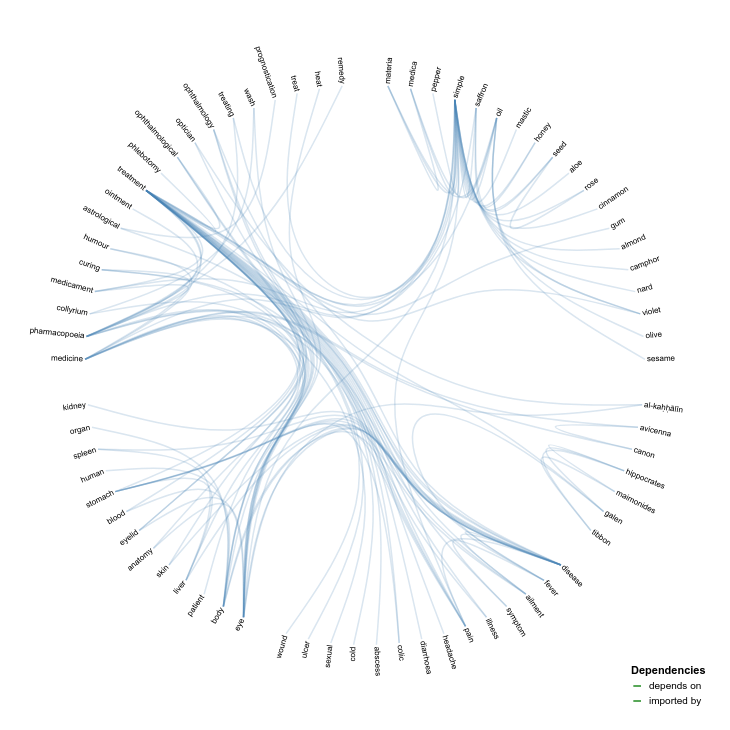

In [84]:
alt.vega.v3.vega(vega_radial_co_occurance_json)

# Test...

In [ ]:
df = pd.DataFrame({'a': ['a', 'b', 'c', 'a', 'c', 'b', 'a'], 
                   'b': ['1', '1', '1', '2', '2', '3', '3']})
df

a, b
a, c,
b, c
a, c
a, b

In [ ]:
dfm = pd.merge(df, df, how='left', on='b')
dfm

In [ ]:
# Remove co-occurance with self
dfm1 = dfm[dfm['b_x'] != dfm['b_y']]
dfm1

In [ ]:
dfm2 = dfm1[['b_x', 'b_y']].reset_index().melt(id_vars=['index']).sort_values(['index', 'value']).set_index('index')[['value']]
dfm2

In [ ]:
pd.concat([dfm2[0::2], 
           dfm2[1::2]], axis=1)

In [ ]:
pd.Series(range(len(dfm2))) % 2 == 0

In [ ]:
dfm1[['b_x', 'b_y']].stack().reset_index(1, drop=True).reset_index()

In [ ]:
dfm1[['b_x', 'b_y']].sort_values(by=list(range(15)), ascending=True, axis=1)

In [ ]:
b_max = dfm1[['b_x', 'b_y']].max(axis='columns', numeric_only=False)
b_min = dfm1[['b_x', 'b_y']].min(axis='columns', numeric_only=False)

In [ ]:
pd.concat([dfm1['a'], b_min, b_max], axis=1).drop_duplicates()

### Matrix

In [ ]:
import altair as alt
import numpy as np
import pandas as pd

# Compute x^2 + y^2 across a 2D grid
x, y = np.meshgrid(range(-5, 5), range(-5, 5))
z = x ** 2 + y ** 2

# Convert this grid to columnar data expected by Altair
data = pd.DataFrame({'x': x.ravel(),
                     'y': y.ravel(),
                     'z': z.ravel()})
data

In [ ]:
alt.Chart(data).mark_rect().encode(
    x='x:O',
    y='y:O',
    color='z:Q'
)